In [1]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.tools import argparser
import pandas as pd
import re
from collections import Counter

In [2]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [3]:
import kiwipiepy
print(kiwipiepy.__version__)

0.20.4


In [4]:
from konlpy.tag import Okt

def extract_keywords(text):
    okt = Okt()
    words = okt.pos(text, stem=True)  # Extract words with their part-of-speech tags, stem verbs/adjectives
    keywords = [word for word, tag in words if (tag in ['Noun', 'Adjective']) and len(word)>=2]  # Filter nouns, verbs, adjectives
    return list(set(keywords))  # Remove duplicates and return as a list

In [5]:
def noun_extractor(text):
    return [token.form for token in kiwi.tokenize(text) if len(token.form) > 1 and token.tag.startswith('N')]
    
def keyword_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        if (len(token) != 1):
            results.append(token)
    return ' '.join(results)
    

In [6]:
kiwi.add_user_word("국민의힘", "NNP") 

True

In [7]:
def remove_words_between_tags(text):
    # Define the pattern to match words between "<" and ">"
    pattern = r'<[^>]*>'
    
    # Use re.sub to replace all matches of the pattern with an empty string
    cleaned_text = re.sub(pattern, '', text)
    cleaned_text = cleaned_text.replace('&quot;', ' ')
    return cleaned_text

In [8]:
def get_youtube_comments(api_key, video_id):
    # Set up the YouTube Data API service
    youtube = build('youtube', 'v3', developerKey=api_key)

    # Initial request to get the first page of comments
    comments_request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        maxResults=100  # Adjust as needed, max is 100
    )

    all_comments = []

    while comments_request:
        comments_response = comments_request.execute()

        # Extract comments and metadata from the response
        for comment_thread in comments_response['items']:
            comment_data = {
                'Comment': comment_thread['snippet']['topLevelComment']['snippet']['textDisplay'],
                'Author': comment_thread['snippet']['topLevelComment']['snippet']['authorDisplayName'],
                'LikeCount': comment_thread['snippet']['topLevelComment']['snippet']['likeCount'],
                'PublishedAt': comment_thread['snippet']['topLevelComment']['snippet']['publishedAt'],
            }
            all_comments.append(comment_data)

        # Check if there are more pages of comments
        comments_request = youtube.commentThreads().list_next(comments_request, comments_response)

    return all_comments

In [9]:
if __name__ == "__main__":
    # Replace 'YOUR_API_KEY' with your actual YouTube Data API key
    api_key = '******'

    # Replace 'VIDEO_ID' with the actual ID of the YouTube video
    video_id = 'EaGNjgTt3co'
    # blU7Mxv8RaY

    comments = get_youtube_comments(api_key, video_id)

    # Create a Pandas DataFrame
    df = pd.DataFrame(comments)

    # Display the DataFrame
    # print(df)

In [10]:
#df = pd.read_csv("TrumpZelensky.csv")

In [11]:
df = df.sort_values(by=['LikeCount'], ascending=False)

In [12]:
%matplotlib inline 
import string
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
pd.options.mode.chained_assignment = None
#from nltk.corpus import stopwords
# list of stopwords like articles, preposition
#stop = set(stopwords.words('english'))
from string import punctuation
from collections import Counter
import datetime

In [13]:
df['Comment'] = df['Comment'].apply(remove_words_between_tags)
tokenized = df['Comment'].apply(noun_extractor)
nouns = df['Comment'].apply(noun_extractor)

In [14]:
tokenized

2286                         [언론사, 방송국, 사실, 본인, 희망사항, 보도]
2231    [미국, 언론, 트럼프, 해리스, 박빙, 국내, 언론, 해리스, 압승, 예상, 미국...
1935                                     [이번, 한국, 언론, 진실]
1704                            [자기, 역대, 치열, 접전, 박빙, 딴소리]
2296                                        [국내, 언론사, 수준]
                              ...                        
972                                                    []
970                                  [미국, 문화, 미국, 시민, 행동]
968                                              [환율, 돌파]
967                              [백인, 우월주의, 청년, 흑인, 히스패닉]
1150                                  [미국인, 해리스, 트럼프, 가능]
Name: Comment, Length: 2300, dtype: object

In [15]:
nouns

2286                         [언론사, 방송국, 사실, 본인, 희망사항, 보도]
2231    [미국, 언론, 트럼프, 해리스, 박빙, 국내, 언론, 해리스, 압승, 예상, 미국...
1935                                     [이번, 한국, 언론, 진실]
1704                            [자기, 역대, 치열, 접전, 박빙, 딴소리]
2296                                        [국내, 언론사, 수준]
                              ...                        
972                                                    []
970                                  [미국, 문화, 미국, 시민, 행동]
968                                              [환율, 돌파]
967                              [백인, 우월주의, 청년, 흑인, 히스패닉]
1150                                  [미국인, 해리스, 트럼프, 가능]
Name: Comment, Length: 2300, dtype: object

In [16]:
df['Tokens'] = tokenized

In [17]:
#from openai import OpenAI
#import os
#client = OpenAI(api_key='****')
#def getChatGPTSentiment(txt): 
#    chat_completion = client.chat.completions.create(
#    messages=[
#        {
#            "role": "user",
#            #"content": "Is the sentiment of this text positive, negative, or neutral?  Do not give a long answer and just say Positive, Negative, or Neutral.  If you can't determine the sentiment, just say Neutral.  If there is no text to analyze, just say Neutral." + txt,
#            "content": "Provide a sentiment score of this text on the scale of -1 to 1.  Your answer should be a numerical value.  It should contain no text or period." + txt,
#        }
#    ],
#    model="gpt-4o",)

#    output = chat_completion.choices[0].message.content
#    print(output + '\t' + txt)
#    return output

In [18]:
import openai
import time
import concurrent.futures

client = openai.OpenAI(api_key="******")

def getChatGPTSentiment(txt):
    """Send a single API request and return sentiment score."""
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": f"Provide a sentiment score of this text on the scale of -1 to 1.  Your answer should be a numerical value.  It should contain no text or period. If you don't know the answer, just give me 0: {txt}"}]
        )
        return response.choices[0].message.content if response.choices else None
    except Exception as e:
        print(f"Error processing: {txt}\nError: {e}")
        return None  # Return None if there's an error

def getChatGPTSentimentParallel(comments, max_workers=10):
    """Process sentiment analysis in parallel for a list of comments."""
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks at once
        future_to_text = {executor.submit(getChatGPTSentiment, txt): txt for txt in comments}
        
        for future in concurrent.futures.as_completed(future_to_text):
            results.append(future.result())  # Collect results

    return results

In [19]:
batch_size = 50  # Increase this for better performance
max_threads = 10  # Adjust based on system capability

# Process comments in parallel batches
sentiment_scores = []
count = 1
for i in range(0, len(df), batch_size):
    batch = df['Comment'].iloc[i:i + batch_size].tolist()
    batch_scores = getChatGPTSentimentParallel(batch, max_workers=max_threads)
    sentiment_scores.extend(batch_scores)
    print("Batch " + str(count) + " Done.")
    count += 1

# Assign back to DataFrame
df['Sentiment'] = sentiment_scores

Batch 1 Done.
Batch 2 Done.
Batch 3 Done.
Batch 4 Done.
Batch 5 Done.
Batch 6 Done.
Batch 7 Done.
Batch 8 Done.
Batch 9 Done.
Batch 10 Done.
Batch 11 Done.
Batch 12 Done.
Batch 13 Done.
Batch 14 Done.
Batch 15 Done.
Batch 16 Done.
Batch 17 Done.
Batch 18 Done.
Batch 19 Done.
Batch 20 Done.
Batch 21 Done.
Batch 22 Done.
Batch 23 Done.
Batch 24 Done.
Batch 25 Done.
Batch 26 Done.
Batch 27 Done.
Batch 28 Done.
Batch 29 Done.
Batch 30 Done.
Batch 31 Done.
Batch 32 Done.
Batch 33 Done.
Batch 34 Done.
Batch 35 Done.
Batch 36 Done.
Batch 37 Done.
Batch 38 Done.
Batch 39 Done.
Batch 40 Done.
Batch 41 Done.
Batch 42 Done.
Batch 43 Done.
Batch 44 Done.
Batch 45 Done.
Batch 46 Done.


In [22]:
#df[df['Sentiment'] == '0입니다']
#df.loc[3237, "Sentiment"] = "0"

In [23]:
df['Sentiment'] = df.Sentiment.astype('float')

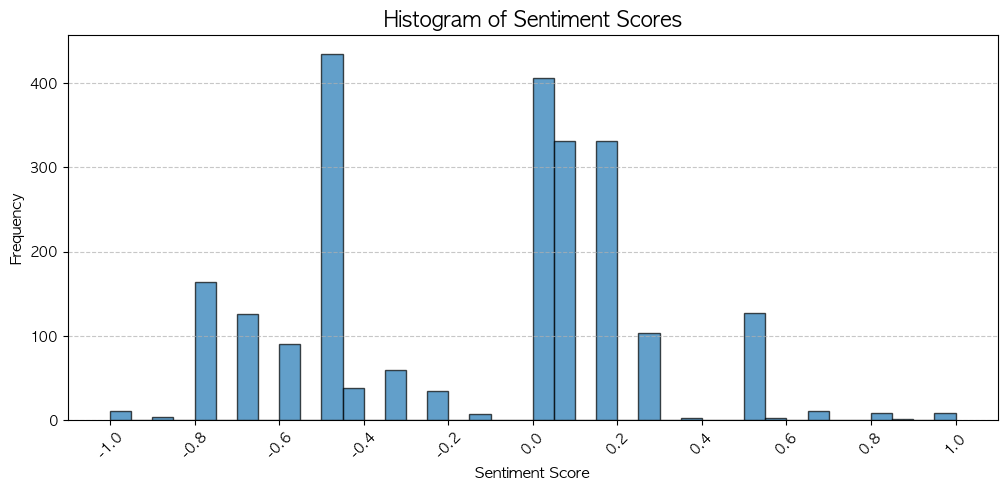

In [24]:
# Set Apple Gothic as the default font
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # Fixes negative sign issue

# Create histogram and capture bin edges
plt.figure(figsize=(12, 5))
counts, bins, patches = plt.hist(df['Sentiment'], bins=40, edgecolor='black', alpha=0.7)

# Define evenly spaced x-ticks including -1, 0, and 1
xticks_labels = np.linspace(-1, 1, num=11)  # Generates 11 evenly spaced ticks from -1 to 1

plt.xticks(xticks_labels, rotation=45, fontsize=10)  # Rotate for better readability
plt.yticks(fontsize=10)

plt.xlabel('Sentiment Score', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Histogram of Sentiment Scores', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
# Flatten the list of lists and count occurrences
all_keywords = [word for sublist in df['Tokens'] for word in sublist]
keyword_counts = Counter(all_keywords)

# Convert to DataFrame for better visualization
keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency'])

# Sort by frequency in descending order
keyword_df = keyword_df.sort_values(by='Frequency', ascending=False)

# Limit to the top 30 most frequent keywords
keyword_df_top30 = keyword_df.head(30)

In [26]:
keyword_df_top30

,Keyword,Frequency
7,언론,979
8,트럼프,621
19,한국,540
6,미국,506
9,해리스,264
10,박빙,232
78,좌파,177
43,우리,162
107,대통령,156
205,민주당,152


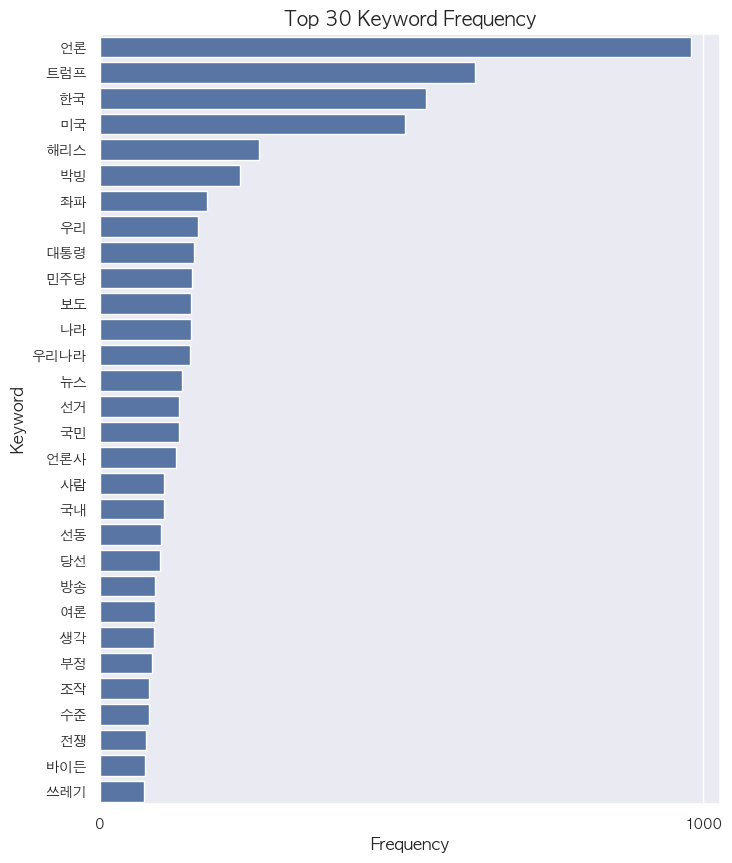

In [27]:
# Setting Seaborn style and Matplotlib parameters
sns.set(style="darkgrid", font='AppleGothic', font_scale=5)

# Plot horizontal barplot using Seaborn
plt.figure(figsize=(8, 10))
sns.barplot(x='Frequency', y='Keyword', data=keyword_df_top30)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add title and labels
plt.title('Top 30 Keyword Frequency', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keyword', fontsize=12)

# Show plot
plt.show()

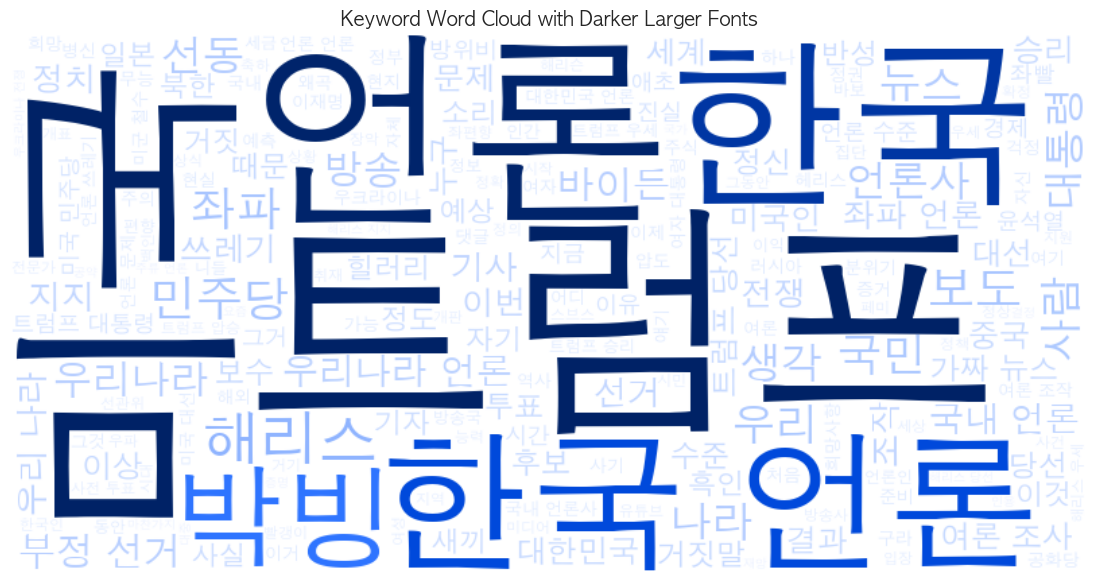

In [28]:
from wordcloud import WordCloud

all_keywords_text = " ".join([word for sublist in df['Tokens'] for word in sublist])

# Define a custom color function where bigger words are darker and smaller words are lighter
def darken_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(220, 100%, {max(20, 100 - font_size // 2)}%)"  # Darker for larger words

# Generate word cloud with improved visibility
wordcloud = WordCloud(
    font_path="/Library/Fonts/AppleGothic.ttf",  # Change this to AppleGothic.ttf if running locally on macOS
    width=800, height=400,
    background_color="white",
    color_func=darken_color_func,  # Apply custom color function
    contour_color='black',  # Outline for better visibility
    contour_width=1.5
).generate(all_keywords_text)

# Plot word cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Keyword Word Cloud with Darker Larger Fonts", fontsize=14)
plt.show()

In [30]:
df.to_csv("TrumpVictory.csv", index=False, encoding="utf-8-sig")

In [31]:
df.head(20)

,Comment,Author,LikeCount,PublishedAt,Tokens,Sentiment
2286,언론사 방송국은 사실을 알리는게 아니고 본인들 희망사항을 보도한거지 뭐 ㅋㅋㅋ,@야만의사회,4841,2024-11-06T09:16:17Z,"[언론사, 방송국, 사실, 본인, 희망사항, 보도]",0.0
2231,미국 언론 트럼프 해리스 초박빙 -&gt; 국내 언론 해리스 압승 예상 미국 ...,@Kim_Doohan,4071,2024-11-06T09:30:00Z,"[미국, 언론, 트럼프, 해리스, 박빙, 국내, 언론, 해리스, 압승, 예상, 미국...",0.0
1935,이번에 느꼈다 한국언론은 진실을 말하려하지 않는다는 걸,@SuGga-s6f,3453,2024-11-06T10:11:52Z,"[이번, 한국, 언론, 진실]",0.2
1704,"sbs 자기들도 역대 가장 치열한 접전, 초박빙, 끝나도 끝난게 아니다 이딴소리나 ...",@yimdongjoo4427,2619,2024-11-06T10:43:42Z,"[자기, 역대, 치열, 접전, 박빙, 딴소리]",0.2
2296,국내 언론사 수준 이지,@시리시,2137,2024-11-06T09:13:57Z,"[국내, 언론사, 수준]",-0.3
1452,언론에 선동이 이래서 무서운거다.. 보여 주고 싶은 거만 보여주는 언론이 대한민국...,@많은생각,1624,2024-11-06T11:22:14Z,"[언론, 선동, 언론, 대한민국]",0.0
2245,박종훈의 지식한방에서 줄곧 얘기 했는데.. 늘 트럼프가 앞서고 있었다고.. 초박...,@Namkisoon,1232,2024-11-06T09:27:04Z,"[박종훈, 지식, 얘기, 트럼프, 박빙]",0.0
2202,한국언론의 현주소,@rivermoon6164,1171,2024-11-06T09:33:57Z,"[한국, 언론, 주소]",0.3
888,국내 언론사 보도국 기자들 국장들 특히 정치부 국제부 다 사표내라 진짜 ㅋㅋㅋ 처음...,@November441,1163,2024-11-06T13:38:54Z,"[국내, 언론사, 보도국, 기자, 국장, 정치부, 국제부, 사표내라, 처음, 트럼프]",0.0
1224,어느누가 그런 댓글을 달았는데...초박빙이 아니라 처음부터 해리스가 트럼프를 앞선적...,@woop5019,994,2024-11-06T12:06:01Z,"[누구, 댓글, 박빙, 처음, 해리스, 트럼프, 정답]",0.0


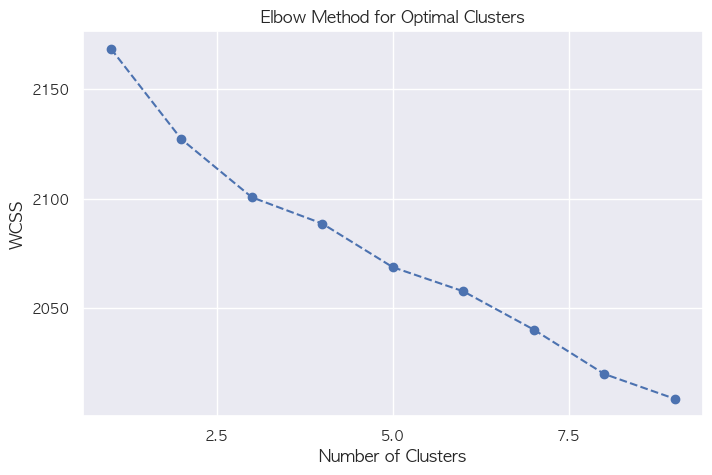

Cluster 0: ['좌파', '언론', '미국', '한국', '선동', '우리나라', '보도', '뉴스', '해리스', '우리']
Cluster 1: ['언론', '한국', '미국', '쓰레기', '트럼프', '우리나라', '해리스', '국내', '뉴스', '보도']
Cluster 2: ['박빙', '언론', '트럼프', '한국', '해리스', '소리', '미국', '우리', '누구', '언론사']
Cluster 3: ['미국', '트럼프', '선거', '우리', '나라', '언론', '부정', '한국', '대통령', '민주당']
Cluster 4: ['트럼프', '언론', '해리스', '한국', '미국', '보도', '대통령', '언론사', '뉴스', '민주당']


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import itertools

# Convert token lists to space-separated strings
df['Tokens_str'] = df['Tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Tokens_str'])

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.title('Elbow Method for Optimal Clusters', fontsize=12)
plt.show()

# Choose an optimal number of clusters (e.g., 4) based on the elbow method
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame
df['Cluster'] = clusters

# Display clustered tokens
clustered_tokens = {}
for i in range(optimal_clusters):
    cluster_tokens = df[df['Cluster'] == i]['Tokens'].explode().dropna().tolist()
    most_common_words = [word for word, _ in Counter(cluster_tokens).most_common(10)]
    clustered_tokens[f'Cluster {i}'] = most_common_words

# Print clustered tokens
for cluster, words in clustered_tokens.items():
    print(f"{cluster}: {words}")

In [33]:
df.head()

,Comment,Author,LikeCount,PublishedAt,Tokens,Sentiment,Tokens_str,Cluster
2286,언론사 방송국은 사실을 알리는게 아니고 본인들 희망사항을 보도한거지 뭐 ㅋㅋㅋ,@야만의사회,4841,2024-11-06T09:16:17Z,"[언론사, 방송국, 사실, 본인, 희망사항, 보도]",0.0,언론사 방송국 사실 본인 희망사항 보도,4
2231,미국 언론 트럼프 해리스 초박빙 -&gt; 국내 언론 해리스 압승 예상 미국 ...,@Kim_Doohan,4071,2024-11-06T09:30:00Z,"[미국, 언론, 트럼프, 해리스, 박빙, 국내, 언론, 해리스, 압승, 예상, 미국...",0.0,미국 언론 트럼프 해리스 박빙 국내 언론 해리스 압승 예상 미국 언론 트럼프 승리 ...,1
1935,이번에 느꼈다 한국언론은 진실을 말하려하지 않는다는 걸,@SuGga-s6f,3453,2024-11-06T10:11:52Z,"[이번, 한국, 언론, 진실]",0.2,이번 한국 언론 진실,1
1704,"sbs 자기들도 역대 가장 치열한 접전, 초박빙, 끝나도 끝난게 아니다 이딴소리나 ...",@yimdongjoo4427,2619,2024-11-06T10:43:42Z,"[자기, 역대, 치열, 접전, 박빙, 딴소리]",0.2,자기 역대 치열 접전 박빙 딴소리,4
2296,국내 언론사 수준 이지,@시리시,2137,2024-11-06T09:13:57Z,"[국내, 언론사, 수준]",-0.3,국내 언론사 수준,4


In [34]:
from collections import defaultdict
import itertools
import pandas as pd

# Create a co-occurrence dictionary
co_occurrence = defaultdict(int)

# Iterate over tokenized comments
for tokens in df['Tokens'].dropna():
    unique_tokens = set(tokens)  # Remove duplicates within the same comment
    for word_pair in itertools.combinations(unique_tokens, 2):  # Create unique word pairs
        co_occurrence[word_pair] += 1

# Convert to a DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=['Word Pair', 'Count'])

# Sort by most frequent word pairs
co_occurrence_df = co_occurrence_df.sort_values(by='Count', ascending=False)

# Display top word pairs
print(co_occurrence_df.head(20))  # Show top 20 word pairs

       Word Pair  Count
86      (한국, 언론)    274
77      (언론, 미국)    140
70     (트럼프, 미국)    135
67     (트럼프, 언론)    133
308     (한국, 미국)     98
71      (박빙, 언론)     88
41     (해리스, 언론)     73
496     (언론, 좌파)     67
996     (국민, 언론)     65
39    (해리스, 트럼프)     65
62      (국내, 언론)     61
182     (보도, 언론)     57
1673   (민주당, 미국)     54
495   (언론, 우리나라)     54
4432   (대통령, 미국)     53
421     (우리, 나라)     53
306    (한국, 트럼프)     53
2481   (해리스, 한국)     51
2865    (부정, 선거)     46
1426    (언론, 뉴스)     45


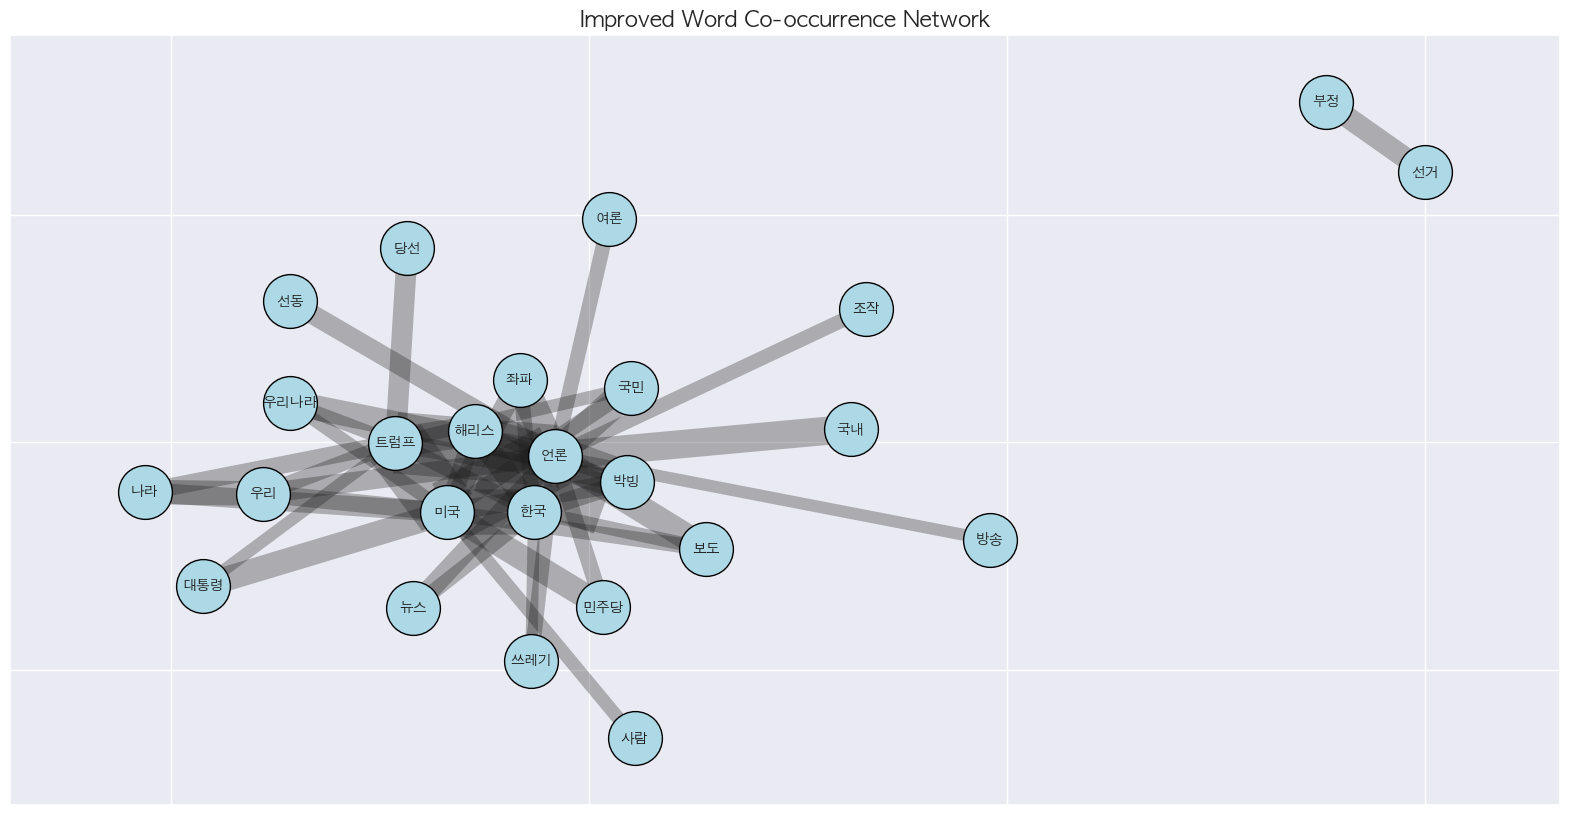

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import pandas as pd

# Set AppleGothic font for Korean text
plt.rcParams['font.family'] = 'AppleGothic'

# Create a co-occurrence dictionary
co_occurrence = defaultdict(int)

# Iterate over tokenized comments
for tokens in df['Tokens'].dropna():
    unique_tokens = set(tokens)  # Remove duplicates within the same comment
    for word_pair in itertools.combinations(unique_tokens, 2):  # Create unique word pairs
        co_occurrence[word_pair] += 1

# Convert to a DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=['Word_Pair', 'Count'])

# Apply a threshold to remove weak connections
min_cooccurrence = 5  # Only keep word pairs that appear together at least 5 times
co_occurrence_df = co_occurrence_df[co_occurrence_df['Count'] >= min_cooccurrence]

# Keep only the top N most frequently mentioned words
top_n_words = 30
word_counts = pd.Series(itertools.chain.from_iterable(df['Tokens'].dropna())).value_counts()
most_common_words = set(word_counts.head(top_n_words).index)

# Filter edges to include only connections between frequent words
filtered_edges = co_occurrence_df[
    co_occurrence_df['Word_Pair'].apply(lambda pair: pair[0] in most_common_words and pair[1] in most_common_words)
]

# Keep only the top 50 strongest connections
filtered_edges = filtered_edges.sort_values(by='Count', ascending=False).head(50)

# Create a graph
G = nx.Graph()

# Add edges and nodes with weight (co-occurrence count)
for word1, word2 in filtered_edges['Word_Pair']:
    count = filtered_edges.loc[filtered_edges['Word_Pair'] == (word1, word2), 'Count'].values[0]
    G.add_edge(word1, word2, weight=count)

# Draw the graph
plt.figure(figsize=(20, 10))

# Improved layout with better spacing
pos = nx.spring_layout(G, k=1.8)  # Increase spacing between nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue', edgecolors='black')

# Draw edges with varying thickness and transparency
edges = nx.draw_networkx_edges(G, pos, width=[d['weight'] / 3 for (u, v, d) in G.edges(data=True)], alpha=0.3)

# Draw labels with a larger font
nx.draw_networkx_labels(G, pos, font_size=10, font_family="AppleGothic", font_weight="bold")

# Show the graph
plt.title("Improved Word Co-occurrence Network", fontsize=16)
plt.show()

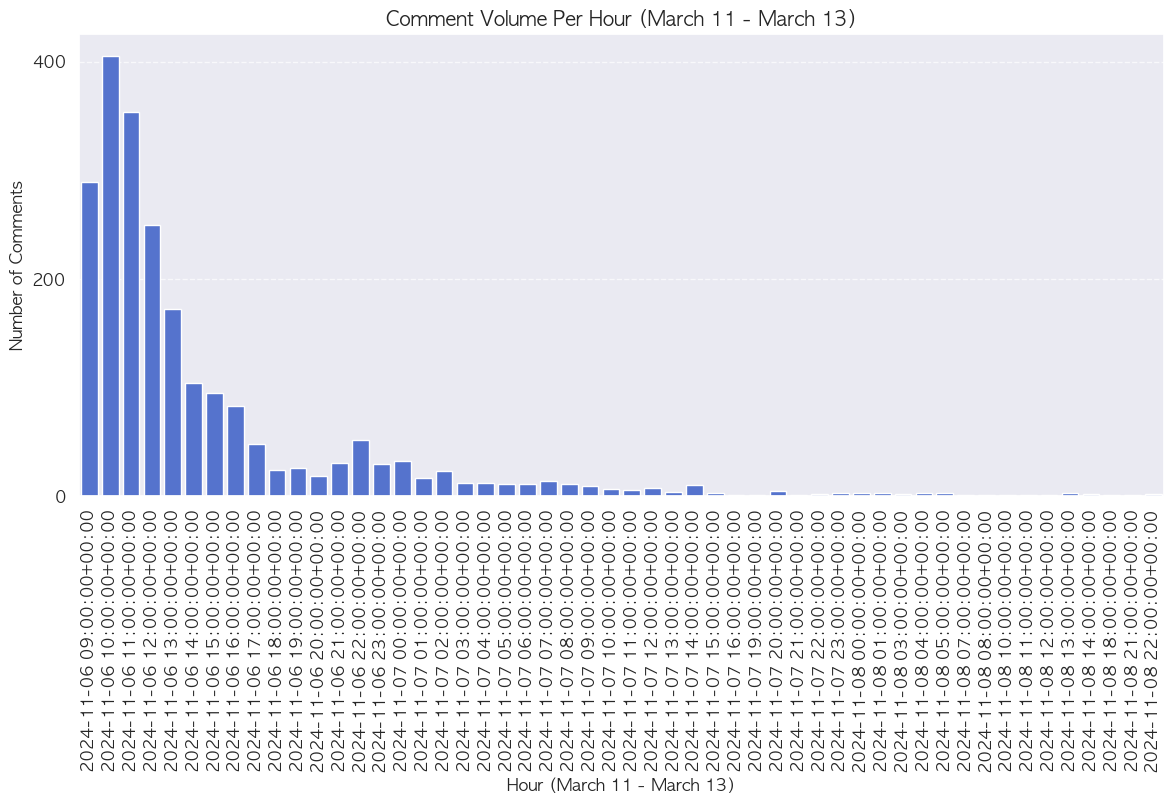

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'PublishedAt' to datetime format
df['PublishedAt'] = pd.to_datetime(df['PublishedAt'], errors='coerce')

# Filter data between March 1 and March 3
start_date = "2024-11-06"
end_date = "2024-11-09"  # Changed end date to include March 3
df_filtered = df[(df['PublishedAt'] >= start_date) & (df['PublishedAt'] < end_date)]

# Create an hourly bin column
df_filtered['Hour_Bin'] = df_filtered['PublishedAt'].dt.floor('h')  # Round down to the nearest hour

# Count the number of comments per hour
hourly_comment_counts = df_filtered.groupby('Hour_Bin').size().reset_index(name='Comment Count')

# Plot using Seaborn
plt.figure(figsize=(14, 6))
sns.barplot(x=hourly_comment_counts['Hour_Bin'], y=hourly_comment_counts['Comment Count'], color='royalblue')

# Formatting
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Hour (March 11 - March 13)', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.title('Comment Volume Per Hour (March 11 - March 13)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


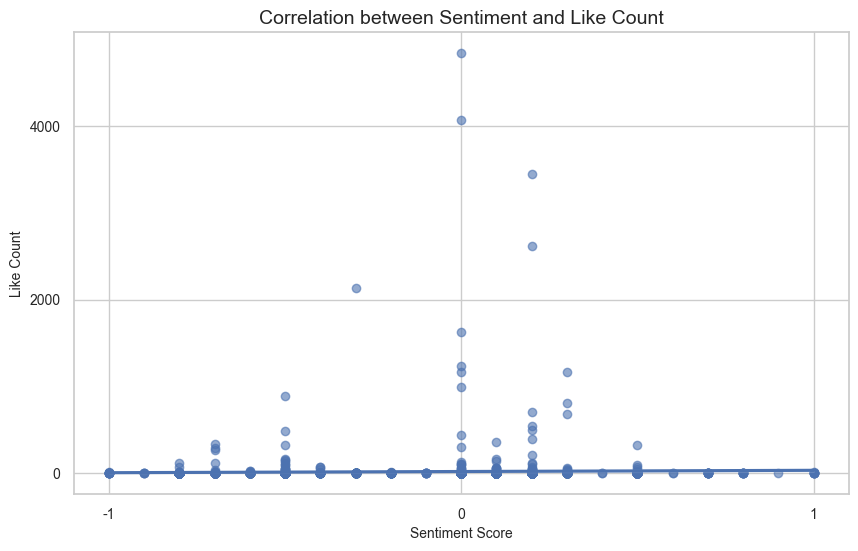

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.regplot(x='Sentiment', y='LikeCount', data=df, scatter_kws={'alpha':0.6})

# Set labels and title
plt.xlabel("Sentiment Score", fontsize=10)
plt.ylabel("Like Count", fontsize=10)
plt.title("Correlation between Sentiment and Like Count", fontsize=14)

# Show plot
plt.show()

In [38]:
df['Length'] = df['Comment'].apply(lambda x: len(x.split()))

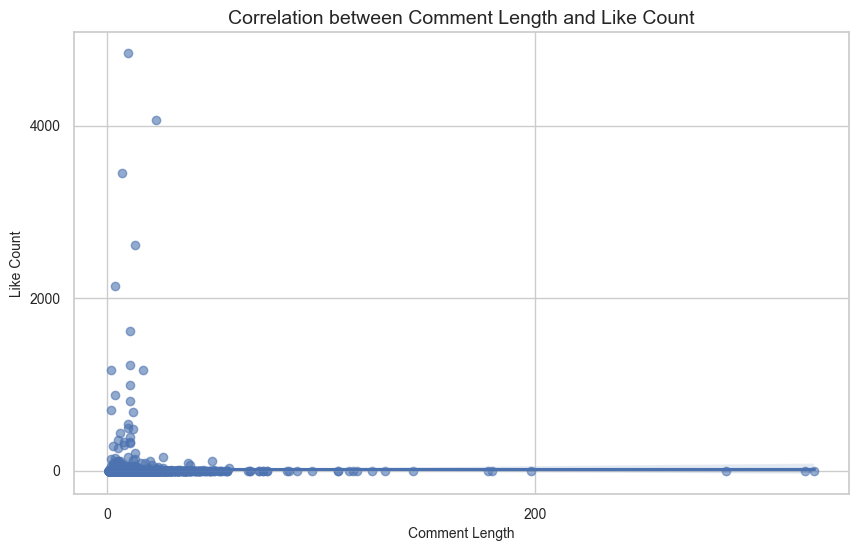

In [39]:
# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.regplot(x='Length', y='LikeCount', data=df, scatter_kws={'alpha':0.6})

# Set labels and title
plt.xlabel("Comment Length", fontsize=10)
plt.ylabel("Like Count", fontsize=10)
plt.title("Correlation between Comment Length and Like Count", fontsize=14)

# Show plot
plt.show()

In [40]:
from IPython.display import display, Markdown
import emoji
from collections import Counter

# Function to extract emojis from text
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Extract and count emojis
all_emojis = df['Comment'].dropna().apply(lambda x: extract_emojis(str(x))).explode().dropna()

# Count occurrences of each emoji
emoji_counts = Counter(all_emojis)

# Convert to DataFrame and sort by frequency
emoji_df = pd.DataFrame(emoji_counts.items(), columns=['Emoji', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Convert emojis to Markdown format for larger display
emoji_df['Emoji'] = emoji_df['Emoji'].apply(lambda x: f"<span style='font-size:48px'>{x}</span>")

# Display in Markdown format (works in Jupyter)
display(Markdown(emoji_df.to_markdown(index=False)))

| Emoji                                  |   Frequency |
|:---------------------------------------|------------:|
| <span style='font-size:48px'>😂</span> |          61 |
| <span style='font-size:48px'>🎉</span> |          44 |
| <span style='font-size:48px'>🥳</span> |          43 |
| <span style='font-size:48px'>👎</span> |          23 |
| <span style='font-size:48px'>😅</span> |          21 |
| <span style='font-size:48px'>😮</span> |          18 |
| <span style='font-size:48px'>❤</span>  |          16 |
| <span style='font-size:48px'>😊</span> |          11 |
| <span style='font-size:48px'>👍</span> |          10 |
| <span style='font-size:48px'>😩</span> |          10 |
| <span style='font-size:48px'>😢</span> |           8 |
| <span style='font-size:48px'>🤣</span> |           7 |
| <span style='font-size:48px'>😈</span> |           7 |
| <span style='font-size:48px'>😎</span> |           6 |
| <span style='font-size:48px'>💭</span> |           4 |
| <span style='font-size:48px'>👩</span> |           3 |
| <span style='font-size:48px'>🔥</span> |           3 |
| <span style='font-size:48px'>🧑</span> |           2 |
| <span style='font-size:48px'>😱</span> |           2 |
| <span style='font-size:48px'>🏿</span> |           2 |
| <span style='font-size:48px'>👨</span> |           2 |
| <span style='font-size:48px'>▶</span>  |           1 |
| <span style='font-size:48px'>🤦</span> |           1 |
| <span style='font-size:48px'>👅</span> |           1 |
| <span style='font-size:48px'>🌶</span>  |           1 |
| <span style='font-size:48px'>🙃</span> |           1 |
| <span style='font-size:48px'>🕷</span>  |           1 |
| <span style='font-size:48px'>😁</span> |           1 |
| <span style='font-size:48px'>🤍</span> |           1 |
| <span style='font-size:48px'>☺</span>  |           1 |
| <span style='font-size:48px'>🫡</span>  |           1 |
| <span style='font-size:48px'>😔</span> |           1 |
| <span style='font-size:48px'>✂</span>  |           1 |
| <span style='font-size:48px'>🎂</span> |           1 |
| <span style='font-size:48px'>🍷</span> |           1 |
| <span style='font-size:48px'>🏳</span>  |           1 |
| <span style='font-size:48px'>🌈</span> |           1 |
| <span style='font-size:48px'>🚔</span> |           1 |
| <span style='font-size:48px'>👶</span> |           1 |
| <span style='font-size:48px'>🪪</span>  |           1 |
| <span style='font-size:48px'>😘</span> |           1 |
| <span style='font-size:48px'>💋</span> |           1 |
| <span style='font-size:48px'>🏼</span> |           1 |
| <span style='font-size:48px'>💵</span> |           1 |
| <span style='font-size:48px'>⚠</span>  |           1 |
| <span style='font-size:48px'>☪</span>  |           1 |
| <span style='font-size:48px'>🦰</span> |           1 |
| <span style='font-size:48px'>😡</span> |           1 |